# Data Science 2 Seminar paper
## Business/project evaluation stage

### Premise
What is the effect of personal travel on CoViD-19 infection rates in the tri-state area?
As some of the possible factors I will look into:
- open vs closed borders  
- open vs closed stores 
- vacation times

Since border traffic was never entirely shut down for business traffic i.e. commuters we won't look into that. 

The hypothesis is that all 3 factores have an impact on infection rates. If that can be shown, I will try to form a prediction model for future holidays.

### Preliminary plan of action
* Define area of relevance based on travel/shopping/commute
* Evaluate infection response/delay windows to apply to infection timelines
* Construct an infection spike timeline for border region. 
  * Combined and statebased.
  * Classify days as rising infection/not
* Construct independent/combined timelines for borders' state, stores' state and vacation times. 
* Test correlation to CoViD-19 statistics in the involved countries/overall
* Classify spike events as border/store/vacation
* See if a prediction can be made



### Data evaluation

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta

from utility.helpers import *
import utility.init as util

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slowe


## Importing data

In [17]:
emr_df = pd.read_csv(util.emr_infection_data)
de_ref_df = pd.read_csv(util.de_reference_data)
nl_ref_df = pd.read_csv(util.nl_reference_data)
be_ref_df = pd.read_csv(util.be_reference_data)

# add date typ columns
emr_df = addDateTypeColumn(emr_df,'XDate')
de_ref_df = addDateTypeColumn(de_ref_df,'XDate')
nl_ref_df = addDateTypeColumn(nl_ref_df,'XDate')
be_ref_df = addDateTypeColumn(be_ref_df,'XDate')

# Sketch

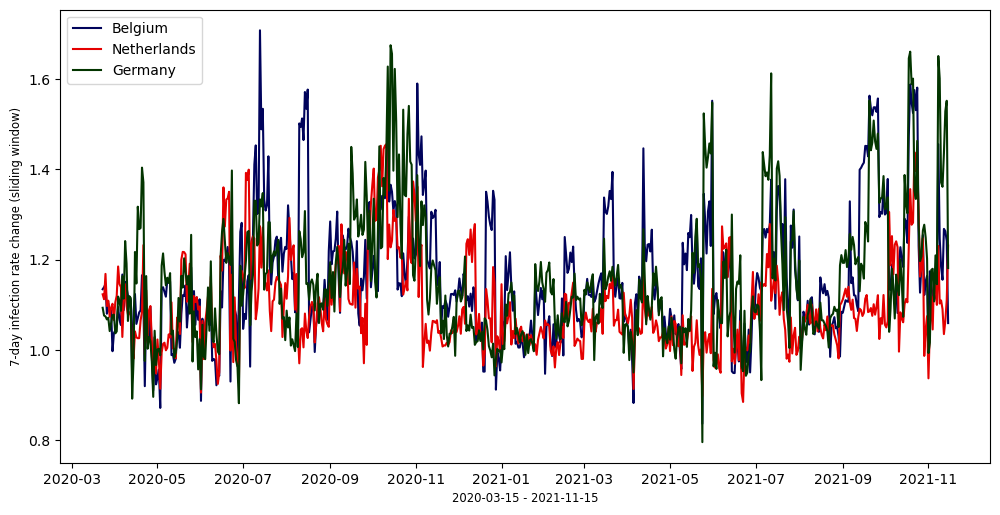

In [18]:
addProvince(emr_df, 10)
addProvince(emr_df, 20)
addProvince(emr_df, 30)

plt.legend()
plt.show()

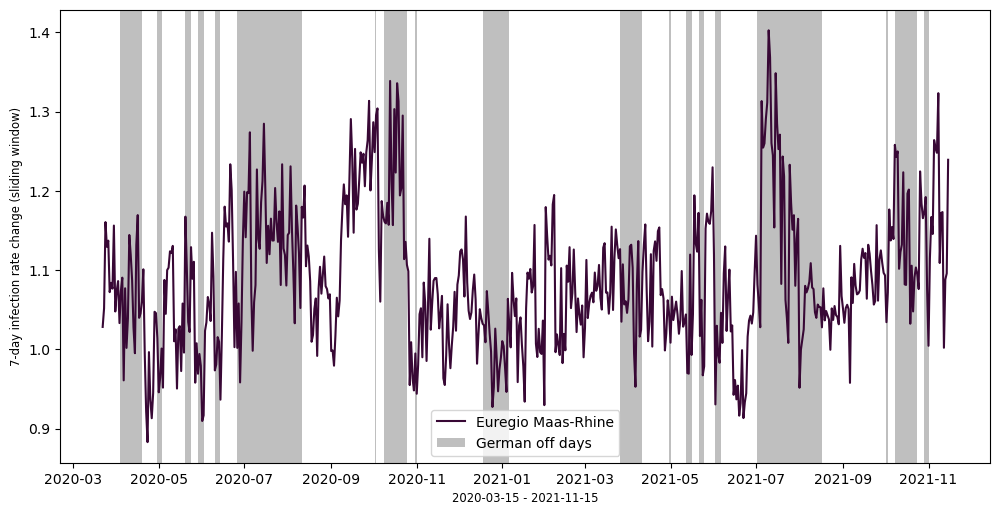

In [19]:
# sketchGraph(emr_df, {30}, de_ref_df, 'German off days')

# sketchGraph(emr_df, {30}, nl_ref_df, 'Dutch off days')

# sketchGraph(emr_df, {30}, be_ref_df, 'Belgian off days')

# sketchGraph(emr_df, {20}, be_ref_df, 'Dutch off days')

# sketchGraph(emr_df, {10}, be_ref_df, 'Belgian off days')

sketchGraph(emr_df, {40}, de_ref_df, 'German off days')

# Delay/Vacation weight factor example

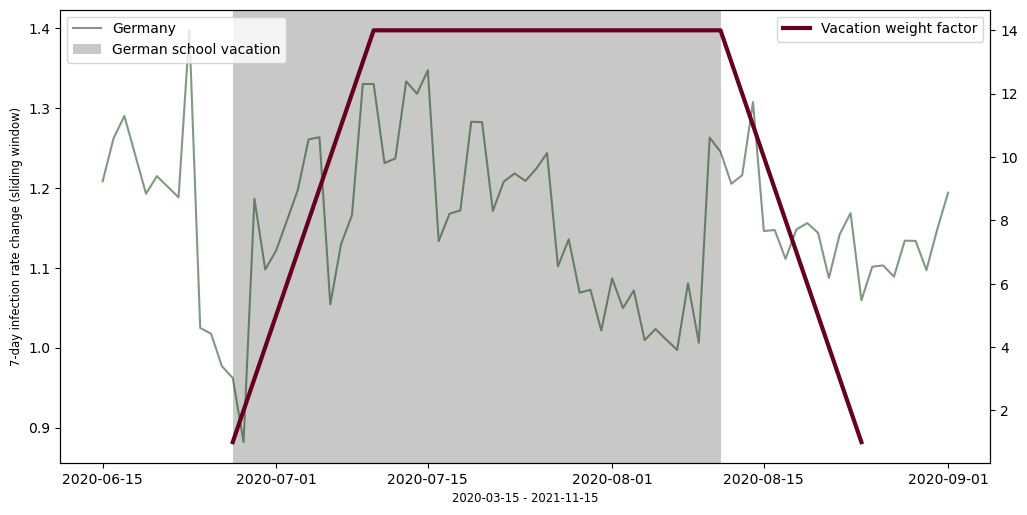

In [20]:
def cutToTimeframe(df, start='2020-06-15', end='2020-09-01'):
    df_c = df.copy()
    df_c = df_c.loc[df_c['Date'] >= start]
    df_c = df_c.loc[df_c['Date'] <= end]
    return df_c

delay_emr_df = cutToTimeframe(emr_df)
delay_de_ref_df = cutToTimeframe(de_ref_df)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

x = delay_emr_df.loc[delay_emr_df['Province_Id']== 30, 'XDate']
y = delay_emr_df.loc[delay_emr_df['Province_Id']== 30, 'N_Day_Rate_Change_Sliding_Window']
ax1.set_xlabel( util.timeframe_start + " - " + util.timeframe_end ,fontdict=util.font)
ax1.set_ylabel( str(util.incident_window_size)+"-day infection rate change (sliding window)" ,fontdict=util.font)
ax1.plot(x,y, label = util.class_labels[30], color = util.class_colors[30],alpha=0.5)

ax1.axvspan('2020-06-27', dt.strptime('2020-08-11',"%Y-%m-%d"), facecolor='xkcd:grey',alpha=0.5, label='German school vacation')

delay_factor = cutToTimeframe(de_ref_df)
delay_factor['Day_Off'] = ( delay_factor['Holiday'] + delay_factor['Vacation'] ) > 0
delay_factor['Factor'] = delay_factor['Day_Off'].rolling(14).apply(lambda x : np.sum(x), raw=True)
delay_factor.loc[delay_factor['Date'] =='2020-06-27', 'Factor'] = 1

for i in range(13):
    d = dt.strptime('2020-07-17',"%Y-%m-%d")+timedelta(days = i)
    delay_factor.loc[delay_factor['XDate'] == d.date(), 'Factor'] = 13-i
delay_factor = delay_factor[delay_factor.Factor > 0]


x = delay_factor['XDate']
y = delay_factor['Factor']
ax2.plot(x,y, color='xkcd:maroon', label="Vacation weight factor", linewidth=3)


# add delay block
# plt.axvspan(dt.strptime('2020-06-27',"%Y-%m-%d")+timedelta(days = 5), dt.strptime('2020-08-11',"%Y-%m-%d")+timedelta(days = 10), alpha=0.5, facecolor='grey', hatch='\\', ymax=0.8, label='Relevance span')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


# Inhabitants

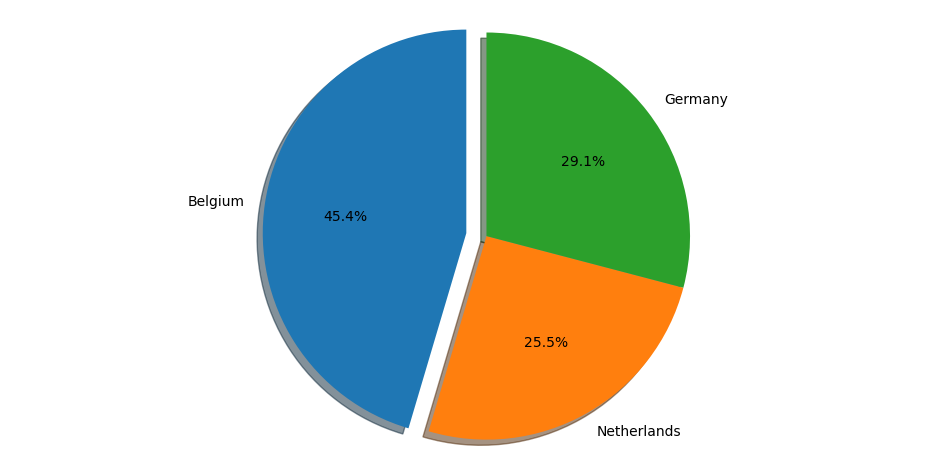

In [21]:
province_df = pd.DataFrame(util.province_size.items(), columns=['Id','Inhabitants'])
province_df['Label'] = util.class_labels.values()
province_df['Explode'] = 0
province_df.loc[province_df['Id'] == 10 ,'Explode'] = 0.1

province_df = province_df.loc[province_df['Id'].isin({10,20,30})]

explode = tuple(list(province_df['Explode']))  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(province_df['Inhabitants'], explode=explode, labels=province_df['Label'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.set_facecolor('white')
plt.show()

# Scatter

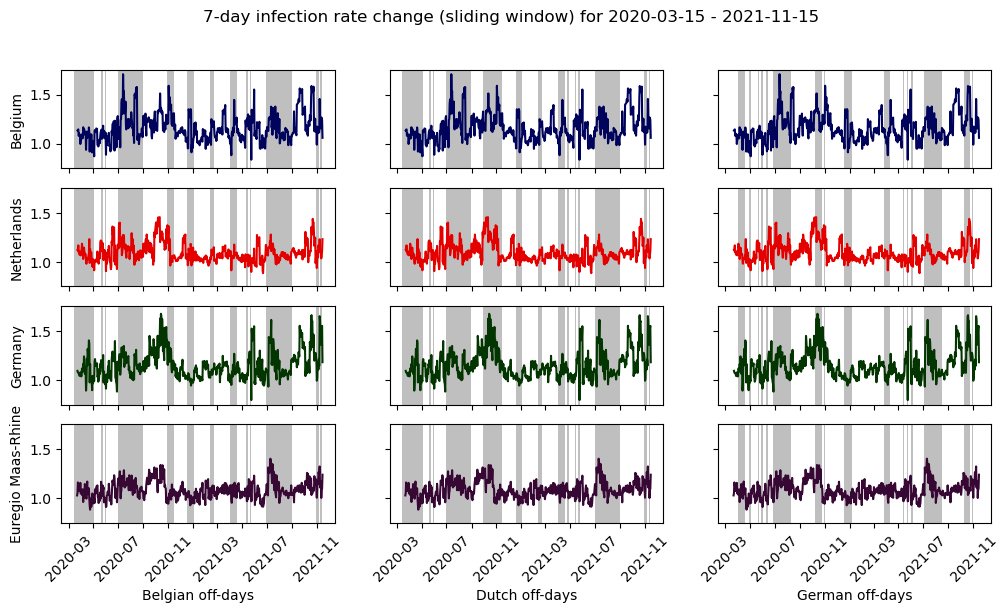

In [29]:
def addToMatrixPlot(df, ax, id, ref_df):
    x = df.loc[df['Province_Id']== id, 'XDate']
    y = df.loc[df['Province_Id']== id, 'N_Day_Rate_Change_Sliding_Window']
    ax.plot(x, y, color=util.class_colors[id])
    addDayOffStreaksToAx(ref_df, ax)
    ax.set_ylabel(util.class_labels[id])


fig, axs = plt.subplots(4,3, sharex=True, sharey=True)

for id in range(0,4):
    addToMatrixPlot(emr_df, axs[id, 0], (id+1)*10, be_ref_df)
    addToMatrixPlot(emr_df, axs[id, 1], (id+1)*10, nl_ref_df)
    addToMatrixPlot(emr_df, axs[id, 2], (id+1)*10, de_ref_df)

axs[3, 2].set_xlabel("German off-days")
axs[3, 1].set_xlabel("Dutch off-days")
axs[3, 0].set_xlabel("Belgian off-days")

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    show = True
    for label in ax.xaxis.get_ticklabels():
        # label is a Text instance
        label.set_rotation(45)
        if not show:
            label.set_visible(False)
            show = True
        else:
            show = False

fig.suptitle(str(util.incident_window_size)+"-day infection rate change (sliding window) for " + util.timeframe_start + " - " + util.timeframe_end)
plt.show()

# Data

In [35]:
# for name, id in util.province_id.items():
#     print(name +": "+ str(util.province_size[id]))

emr_df

Belgium: 1987170
Liege, Belgium: 1109800
Limburg, Belgium: 877370
Netherlands: 1115895
Limburg, Netherlands: 1115895
Germany: 1272588
StädteRegion Aachen: 556631
LK Düren: 265140
LK Heinsberg: 256458
LK Euskirchen: 194359
Euregio Maas-Rhine: 4375653
